## Import and explore public dataset on UK road traffic accidents
#### Data available from Kaggle: https://www.kaggle.com/daveianhickey/2000-16-traffic-flow-england-scotland-wales
#### Guide to column defintions available here: https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=7752&type=Data%20catalogue#!/documentation

### To do:
#### Expand or reduce dimensions/ categories
#### Explore accident severity threshold values - how many "edge cases" are predicted with accident severity ~0.5? (for regression rather than classification)
#### Write results to a table and save

#### Helpful links for strategies to improve classification accuracy when dataset is unbalanced
https://www.reddit.com/r/MachineLearning/comments/12evgi/classification_when_80_of_my_training_set_is_of/

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

### 1. Import data from DBFS

In [5]:
# File location and type

def create_dataframe (location):
  

  #file_location = "/FileStore/tables/accidents_2012_to_2014.csv"
  #file_location = "/FileStore/tables/accidents_2009_to_2011.csv"

  file_type = "csv"

  # CSV options
  infer_schema = "true"
  first_row_is_header = "true"
  delimiter = ","

  # The applied options are for CSV files. For other file types, these will be ignored.
  df = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .load(location)
  
  return(df)

# import three csv files, corresponding to different time periods, and save each to a table

# illegal characters for saveastable but not for createorreplacetempview
df_0507 = create_dataframe("/FileStore/tables/accidents_2005_to_2007.csv")
temp_table_name = "accidents_0507"
df_0507.createOrReplaceTempView(temp_table_name)


df_0911 = create_dataframe("/FileStore/tables/accidents_2009_to_2011.csv")
temp_table_name = "accidents_0911"
df_0911.createOrReplaceTempView(temp_table_name)


df_1214 = create_dataframe("/FileStore/tables/accidents_2012_to_2014.csv")
temp_table_name = "accidents_1214"
df_1214.createOrReplaceTempView(temp_table_name)

In [6]:
%sql
-- merge csv tables
-- UNION works here, but is it the right join given the similarity of the three tables?
CREATE OR REPLACE TEMPORARY VIEW joined_tables AS
(SELECT *
FROM accidents_0911
UNION
SELECT *
FROM accidents_1214
UNION 
SELECT *
FROM accidents_0507)

In [7]:
%sql
DROP TABLE IF EXISTS joined_tables_delta

In [8]:
%sql
-- in order to update table values the table must be converted to a "delta table"
-- only select columns I will need later here for simplicity/brevity
CREATE TABLE joined_tables_delta
USING delta
AS SELECT Accident_severity, Road_Type, Speed_limit,
Light_Conditions, Weather_Conditions, Road_Surface_Conditions, Urban_or_Rural_Area, day_of_week, Carriageway_hazards, Time
from joined_tables;

In [9]:
%sql
SELECT Accident_severity, count(1)
FROM joined_tables_delta
GROUP BY Accident_severity
ORDER BY Accident_severity ASC

Accident_severity,count(1)
1,19041
2,198920
3,1252034


#### Data transformations
1. Convert accident severity into a binary variable: 0 for minor, 1 for serious + fatal grouped together
2. Convert time of day into a categorical variable: 1 for 00:00 - 06:00, 2 for 06:01 - 12:00, 3 for 12:01 - 18:00, 4 for 18:01 - 23:59 (or similar) 
#####Caching joined_tables_delta may speed the data transformation up

In [11]:
%sql
-- not sure if caching speeds things up much
CACHE TABLE joined_tables_delta

In [12]:
%sql
-- transform accident severity from three classes (minor, serious and fatal) to two classes (minor and serious) by bundling
-- serious and fatal together, relabling serious + fatal as "1" and relabling minor as "0"

UPDATE joined_tables_delta
SET Accident_severity = 0
WHERE Accident_severity = 3



In [13]:
%sql
UPDATE joined_tables_delta
SET Accident_severity = 1
WHERE Accident_severity = 2

In [14]:
%sql
SELECT Accident_severity, count(1)
FROM joined_tables_delta
GROUP BY Accident_severity
ORDER BY Accident_severity

Accident_severity,count(1)
0,1252034
1,217961


In [15]:
%sql
-- time column is a string in delta table, convert to seconds elapsed since midnight with unix_timestamp function
SELECT TIME
FROM joined_tables_delta
LIMIT 10

TIME
17:49
16:18
18:08
10:00
17:01
08:38
09:40
12:55
12:22
07:55


In [16]:
%sql
UPDATE joined_tables_delta
SET Time = 'Night'
WHERE unix_timestamp(Time, 'HH:mm')<= unix_timestamp('06:00', 'HH:mm')

In [17]:
%sql
UPDATE joined_tables_delta
SET Time = 'Morning'
WHERE unix_timestamp(Time, 'HH:mm')> unix_timestamp('06:00', 'HH:mm') AND unix_timestamp(Time, 'HH:mm')<= unix_timestamp('12:00', 'HH:mm')

In [18]:
%sql
UPDATE joined_tables_delta
SET Time = 'Afternoon'
WHERE unix_timestamp(Time, 'HH:mm')> unix_timestamp('12:00', 'HH:mm') AND unix_timestamp(Time, 'HH:mm')<= unix_timestamp('18:00', 'HH:mm')

In [19]:
%sql
UPDATE joined_tables_delta
SET Time = 'Evening'
WHERE unix_timestamp(Time, 'HH:mm')> unix_timestamp('18:00', 'HH:mm') AND unix_timestamp(Time, 'HH:mm')<= unix_timestamp('23:59', 'HH:mm')

In [20]:
%sql
SELECT TIME
FROM joined_tables_delta
GROUP BY TIME

TIME
Evening
null
Morning
Afternoon
Night


### 3. Main task: train classifiers to for predicting accident severity given hand-picked inputs

### 4. Convert table subset to pandas dataframe

In [23]:
# select limited subset of available columns (preferring non-geographic-specific data types)
# remove unknown and null values (is this necessary?)

spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# removed Urban_or_Rural_Area
pdDF = sql("""SELECT Accident_severity, Road_Type, speed_limit
Light_Conditions, Weather_Conditions, Road_Surface_Conditions, day_of_week, Urban_or_Rural_Area, Time
FROM joined_tables_delta
WHERE (Road_Type <> 'Unknown' AND Weather_Conditions <> 'Unknown' AND Road_Surface_Conditions IS NOT NULL 
AND Time IS NOT NULL AND Urban_or_Rural_Area <> 3)""").toPandas()

/databricks/python/lib/python3.6/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
 warnings.warn("pyarrow.open_stream is deprecated, please use "

### 5. Test-train split

In [25]:
from sklearn.model_selection import train_test_split

X = pdDF.drop("Accident_severity", axis=1)
y = pdDF["Accident_severity"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(y_train))

1147587

### 6. Linear regression, Decision Tree, Random Forest and SVM classification pipelines, all with one-hot encoding

In [27]:
%python
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics
import numpy as np

# can't beat simply guessing the same class for all cases

# not sure how the one hot encoding works here. Does the function look for string columns automatically?
ohe = ("ohe", OneHotEncoder(handle_unknown="ignore")) # converts input to a vector of 0 and 1, of length equal to the number of features
# e.g. length = 7 days of the week + 5 light conditions + 7 road surface types etc

# set classifier hyper-paramters
#class1 = ("lr", LinearRegression(fit_intercept=True, normalize=True))
class1 = ("lr", SGDClassifier(max_iter = 1000, tol = 1E-3))

class2 = ("lr2", DecisionTreeClassifier(random_state=0, max_depth = 3))  # max_depth = 2,3 - all 3's output
# max_depth>15 - same as linear regressor
class3 = ("lr3", SVC(random_state = 0, kernel = 'rbf', gamma = 0.1, C = 10)) # takes a long time to run
class4 = ('lr4', RandomForestClassifier(random_state=0, max_depth = 8, n_estimators = 15, criterion = 'entropy'))

def classification(classifier,train_data, train_label, test_data, test_label):
  pipeline = Pipeline(steps = [ohe, classifier]).fit(train_data, train_label)
  pred_label = pipeline.predict(test_data)
  #pred_label = np.asarray([int(np.round(x)) for x in pred_label], dtype = int)
  accuracy = metrics.accuracy_score(test_label, pred_label)
  return accuracy


In [28]:

print('Full dataset accuracy')
print('Accuracy - All same class: ' + str(np.round(metrics.accuracy_score(y_test, np.ones(len(y_test))*0),5)))
print('Accuracy - Lin. Reg.: ' + str(np.round(classification(class1,X_train, y_train, X_test, y_test),5)))
print('Accuracy - Dec. Tree: ' + str(np.round(classification(class2,X_train, y_train, X_test, y_test),5)))
print('Accuracy - Ran. For.: ' + str(np.round(classification(class4,X_train, y_train, X_test, y_test),5)))
#print('Accuracy - SVM: ' + str(np.round(classification(class3,X_train, y_train, X_test, y_test),5)))



Full dataset accuracy
Accuracy - All same class: 0.85048
Accuracy - Lin. Reg.: 0.85048
Accuracy - Dec. Tree: 0.85048
Accuracy - Ran. For.: 0.85048

In [29]:
# consider <50% threshold for lethality (i.e. no rounding of classification output)

### 7. Try undersampling to balance the dataset (obtain roughly equal numbers of the three accident_severity classes)

In [31]:
import pandas as pd
g = pdDF.groupby('Accident_severity')
# does this undersample? How does it work? Seems to take random subset
g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
# undersampled dataset requires further exploration to check the size and composition

## Convert into Spark DataFrame
spark_g = spark.createDataFrame(g)
## Write Frame out as Table
spark_g.write.mode("overwrite").saveAsTable("under_sampled")

In [32]:
%sql
SELECT Accident_severity, count(1)
FROM under_sampled
GROUP BY Accident_severity
ORDER BY Accident_severity

Accident_severity,count(1)
0,214191
1,214191


In [33]:
X_und = g.drop("Accident_severity", axis=1)
y_und = g["Accident_severity"].values
X_train_und, X_test_und, y_train_und, y_test_und = train_test_split(X_und, y_und, test_size=0.2, random_state=42)

In [34]:
print("Accuracy on undersmapled dataset")
print('Accuracy - All same class: ' + str(np.round(metrics.accuracy_score(y_test_und, np.ones(len(y_test_und))*0),5)))
print('Accuracy - Lin. Reg.: ' + str(np.round(classification(class1,X_train_und, y_train_und, X_test_und, y_test_und),5)))
print('Accuracy - Dec. Tree: ' + str(np.round(classification(class2,X_train_und, y_train_und, X_test_und, y_test_und),5)))
#print('Accuracy - SVM: ' + str(np.round(classification(class3,X_train_und, y_train_und, X_test_und, y_test_und),5)))
print('Accuracy - Ran. For.: ' + str(np.round(classification(class4,X_train_und, y_train_und, X_test_und, y_test_und),5)))


print('')
print("Trained on undersampled dataset; tested on full dataset")
print('Accuracy - All same class: ' + str(np.round(metrics.accuracy_score(y_test, np.ones(len(y_test))*0),5)))
print('Accuracy - Lin. Reg.: ' + str(np.round(classification(class1,X_train_und, y_train_und, X_test, y_test),5)))
print('Accuracy - Dec. Tree: ' + str(np.round(classification(class2,X_train_und, y_train_und, X_test, y_test),5)))
#print('Accuracy - SVM: ' + str(np.round(classification(class3,X_train_und, y_train_und, X_test, y_test),5)))
print('Accuracy - Ran For.: ' + str(np.round(classification(class4,X_train_und, y_train_und, X_test, y_test),5)))


Accuracy on undersmapled dataset
Accuracy - All same class: 0.50069
Accuracy - Lin. Reg.: 0.56044
Accuracy - Dec. Tree: 0.56076
Accuracy - Ran. For.: 0.57284

Trained on undersampled dataset; tested on full dataset
Accuracy - All same class: 0.85048
Accuracy - Lin. Reg.: 0.71314
Accuracy - Dec. Tree: 0.74127
Accuracy - Ran For.: 0.63389

### 8. Try oversampling the minority class (obtain roughly equal numbers of the three accident_severity classes)

In [36]:
max_size = pdDF['Accident_severity'].value_counts().max()
lst = [pdDF]
for class_index, group in pdDF.groupby('Accident_severity'):
    lst.append(group.sample(max_size-len(group), replace=True))
h = pd.concat(lst)

In [37]:
## Convert into Spark DataFrame
spark_h = spark.createDataFrame(h)
## Write Frame out as Table
spark_h.write.mode("overwrite").saveAsTable("over_sampled")

In [38]:
%sql
SELECT Accident_severity, count(1)
FROM over_sampled
GROUP BY Accident_severity

Accident_severity,count(1)
1,1220293
0,1220293


In [39]:
X_ovr = h.drop("Accident_severity", axis=1)
y_ovr = h["Accident_severity"].values
X_train_ovr, X_test_ovr, y_train_ovr, y_test_ovr = train_test_split(X_ovr, y_ovr, test_size=0.2, random_state=42)

In [40]:
print("Accuracy on oversmapled dataset")
print('Accuracy - All same class: ' + str(np.round(metrics.accuracy_score(y_test_ovr, np.ones(len(y_test_ovr))*0),5)))
print('Accuracy - Lin. Reg.: ' + str(np.round(classification(class1,X_train_ovr, y_train_ovr, X_test_ovr, y_test_ovr),5)))
print('Accuracy - Dec. Tree: ' + str(np.round(classification(class2,X_train_ovr, y_train_ovr, X_test_ovr, y_test_ovr),5)))
#print('Accuracy - SVM: ' + str(np.round(classification(class3,X_train_und, y_train_und, X_test_und, y_test_und),5)))
print('Accuracy - Ran. For.: ' + str(np.round(classification(class4,X_train_ovr, y_train_ovr, X_test_ovr, y_test_ovr),5)))


print('')
print("Trained on oversmapled dataset; tested on full dataset")
print('Accuracy - All same class: ' + str(np.round(metrics.accuracy_score(y_test, np.ones(len(y_test))*0),5)))
print('Accuracy - Lin. Reg.: ' + str(np.round(classification(class1,X_train_ovr, y_train_ovr, X_test, y_test),5)))
print('Accuracy - Dec. Tree: ' + str(np.round(classification(class2,X_train_ovr, y_train_ovr, X_test, y_test),5)))
#print('Accuracy - SVM: ' + str(np.round(classification(class3,X_train_und, y_train_und, X_test, y_test),5)))
print('Accuracy - Ran For.: ' + str(np.round(classification(class4,X_train_ovr, y_train_ovr, X_test, y_test),5)))


Accuracy on oversmapled dataset
Accuracy - All same class: 0.50046
Accuracy - Lin. Reg.: 0.55929
Accuracy - Dec. Tree: 0.5585
Accuracy - Ran. For.: 0.5721

Trained on oversmapled dataset; tested on full dataset
Accuracy - All same class: 0.85048
Accuracy - Lin. Reg.: 0.71314
Accuracy - Dec. Tree: 0.74127
Accuracy - Ran For.: 0.69405

In [41]:
# Confusion matrix visualisation
# accident_severity = 0 -> minor; accident_severity = 1 -> major
# true negative -> correct minor identification
# true positive -> correct major identification
# false positive -> confused minor for major
# false negative -> confused major for minor

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# vary classifier paramters to optimise accuracy
class5 = ('lr5', RandomForestClassifier(random_state=0, max_depth = 16, n_estimators = 12, criterion = 'gini'))
class6 = ('lr6', SGDClassifier(max_iter = 1000, tol = 1E-2, loss = 'log', penalty = 'elasticnet'))

pipeline = Pipeline(steps = [ohe, class6]).fit(X_train_ovr, y_train_ovr)
pred_label = pipeline.predict(X_test_ovr)
print(pred_label[0:10])
#pred_label = np.asarray([int(np.round(x)) for x in pred_label], dtype = int) # when is this necessary?
accuracy = metrics.accuracy_score(y_test_ovr, pred_label)
cf_mat = confusion_matrix(y_test_ovr, pred_label)
tn, fp, fn, tp = cf_mat.ravel()

print('True negative: ' + str(np.round(tn/np.sum(cf_mat)*100,1)) + ' %')
print('True positive: ' + str(np.round(tp/np.sum(cf_mat)*100,1)) + ' %')
print('False positive: ' + str(np.round(fp/np.sum(cf_mat)*100,1)) + ' %')
print('False negative: ' + str(np.round(fn/np.sum(cf_mat)*100,1)) + ' %')
print('')
print((tn+tp)/np.sum(cf_mat))
# False negative (mistaking a major accident for a minor) is large

[1 1 1 1 1 1 1 0 0 0]
True negative: 28.7 %
True positive: 28.5 %
False positive: 21.3 %
False negative: 21.5 %

0.571511396834372

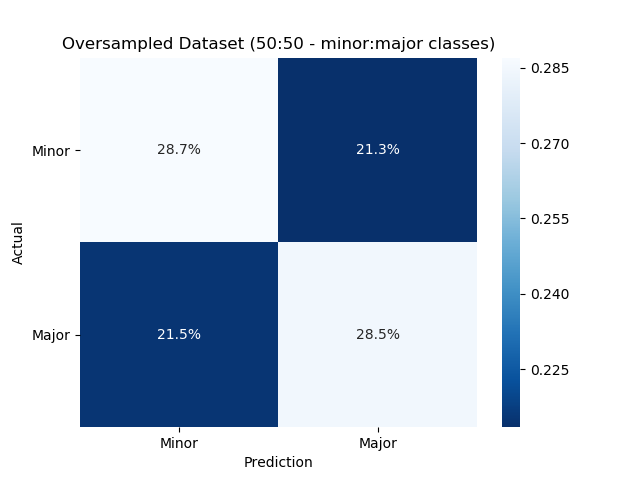

In [42]:


cf_mat = confusion_matrix(y_test_ovr, pred_label)

plt.clf()
ax = plt.axes()
sns.heatmap(cf_mat/np.sum(cf_mat) , annot=True, fmt='.1%', cmap='Blues_r', ax = ax)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.xticks((0.5,1.5),('Minor','Major'))
plt.yticks((0.5,1.5),('Minor','Major'))
plt.yticks(rotation=0)
plt.title('Oversampled Dataset (50:50 - minor:major classes)')
display()




#### 9. Explore optimal input data categories (sometimes fewer is better)

In [44]:
# What is the best way to decide which categories to include?
# some variance in performance
#Accident_severity, Road_Type, speed_limit
#Light_Conditions, Weather_Conditions, Road_Surface_Conditions, day_of_week, Urban_or_Rural_Area

# trim off categories, be careful to avoid nulls
# urban_or_rural seems to add ~0.3 to probability, equally light conditions
import pandas as pd

trimmed = sql("""SELECT Accident_severity,  Urban_or_rural_area, Light_conditions, Road_type, Road_surface_conditions, Weather_conditions,
speed_limit, day_of_week
FROM joined_tables_delta
WHERE (Road_Type <> 'Unknown' AND Weather_Conditions <> 'Unknown' AND Road_Surface_Conditions IS NOT NULL
AND Urban_or_Rural_Area <> 3)""").toPandas()

max_size = trimmed['Accident_severity'].value_counts().max()
lst = [trimmed]
for class_index, group in trimmed.groupby('Accident_severity'):
    lst.append(group.sample(max_size-len(group), replace=True))
h = pd.concat(lst)

X_ovr = h.drop("Accident_severity", axis=1)
y_ovr = h["Accident_severity"].values
X_train_ovr, X_test_ovr, y_train_ovr, y_test_ovr = train_test_split(X_ovr, y_ovr, test_size=0.2, random_state=42)

class5 = ('lr5', RandomForestClassifier(random_state=0, max_depth = 8, n_estimators = 15, criterion = 'entropy'))

pipeline = Pipeline(steps = [ohe, class5]).fit(X_train_ovr, y_train_ovr)
pred_label = pipeline.predict(X_test_ovr)
pred_label = np.asarray([int(np.round(x)) for x in pred_label], dtype = int)
accuracy = metrics.accuracy_score(y_test_ovr, pred_label)
cf_mat = confusion_matrix(y_test_ovr, pred_label)
tn, fp, fn, tp = cf_mat.ravel()

print('True negative: ' + str(tn/np.sum(cf_mat)))
print('True positive: ' + str(tp/np.sum(cf_mat)))
print('False positive: ' + str(fp/np.sum(cf_mat)))
print('False negative: ' + str(fn/np.sum(cf_mat)))
print('')
print((tn+tp)/np.sum(cf_mat))

/databricks/python/lib/python3.6/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
 warnings.warn("pyarrow.open_stream is deprecated, please use "
True negative: 0.3232763565446828
True positive: 0.24867254461725036
False positive: 0.17702273062488733
False negative: 0.2510283682131795

0.5719489011619332